In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/README.md
/kaggle/input/train.csv
/kaggle/input/test.csv
/kaggle/input/images/641.png
/kaggle/input/images/173.png
/kaggle/input/images/491.png
/kaggle/input/images/718.png
/kaggle/input/images/709.png
/kaggle/input/images/379.png
/kaggle/input/images/780.png
/kaggle/input/images/248.png
/kaggle/input/images/94.png
/kaggle/input/images/480.png
/kaggle/input/images/236.png
/kaggle/input/images/771.png
/kaggle/input/images/675.png
/kaggle/input/images/340.png
/kaggle/input/images/48.png
/kaggle/input/images/513.png
/kaggle/input/images/677.png
/kaggle/input/images/350.png
/kaggle/input/images/761.png
/kaggle/input/images/314.png
/kaggle/input/images/655.png
/kaggle/input/images/227.png
/kaggle/input/images/762.png
/kaggle/input/images/726.png
/kaggle/input/images/238.png
/kaggle/input/images/61.png
/kaggle/input/images/377.png
/kaggle/input/images/581.png
/kaggle/input/images/222.png
/kaggle/input/images/330.png
/kaggle/input/images/511.png
/kaggle/input/images/579.png
/kag

In [102]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [101]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**SegNet_with_VGG16**

In [79]:
# Set dataset paths
image_dir = "/kaggle/input/images"
mask_dir = "/kaggle/input/masks"

def load_dataset(image_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []

    # Extract available mask filenames without "-mask"
    mask_files = {filename.split('-mask')[0]: filename for filename in os.listdir(mask_dir)}

    matched_count = 0
    for filename in os.listdir(image_dir):
        base_name = filename.split('.')[0]  # Extract base name
        
        if base_name in mask_files:  # Only keep images that have masks
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_files[base_name])

            img = load_img(img_path, target_size=img_size, color_mode='grayscale')
            mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')

            images.append(img_to_array(img) / 255.0)
            masks.append(img_to_array(mask) / 255.0)
            matched_count += 1
        else:
            print(f"Skipping {filename}: No corresponding mask found.")

    print(f"Total images with masks loaded: {matched_count}")
    return np.array(images).reshape(-1, 256, 256, 1), np.array(masks).reshape(-1, 256, 256, 1)
 
# Load images and masks
X, Y = load_dataset(image_dir, mask_dir) 

Skipping 94.png: No corresponding mask found.
Skipping 771.png: No corresponding mask found.
Skipping 761.png: No corresponding mask found.
Skipping 403.png: No corresponding mask found.
Skipping 35.png: No corresponding mask found.
Skipping 628.png: No corresponding mask found.
Skipping 441.png: No corresponding mask found.
Skipping 296.png: No corresponding mask found.
Skipping 538.png: No corresponding mask found.
Skipping 89.png: No corresponding mask found.
Skipping 411.png: No corresponding mask found.
Skipping 281.png: No corresponding mask found.
Skipping 362.png: No corresponding mask found.
Skipping 660.png: No corresponding mask found.
Skipping 256.png: No corresponding mask found.
Skipping 4.png: No corresponding mask found.
Skipping 588.png: No corresponding mask found.
Skipping 229.png: No corresponding mask found.
Skipping 331.png: No corresponding mask found.
Skipping 575.png: No corresponding mask found.
Skipping 673.png: No corresponding mask found.
Skipping 658.png: 

In [103]:
# Data Preparation (assuming X, y are your data)
X = np.array(X)  # Shape (n_samples, 256, 256, 1)
y= np.array(Y)  # Shape (n_samples, 256, 256, 1)

# Train/Val/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 60/20/20 split

In [104]:
X_train.shape

(422, 256, 256, 1)

In [105]:
#Custom Metrics
def dice_score(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.keras.backend.sum(y_true,[1,2,3])+tf.keras.backend.sum(y_pred,[1,2,3])-intersection
    return tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)


In [112]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, Concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
# SegNet Model
def build_segnet_vgg(input_size=(256, 256, 1)):
    inputs = Input(shape=input_size)
    x_rgb = Concatenate()([inputs, inputs, inputs])
    vgg_base = VGG16(weights='imagenet', include_top=False, input_tensor=x_rgb)
    
    # Freeze VGG16 layers
    for layer in vgg_base.layers:
        layer.trainable = False
    
    # Get intermediate layers
    block5 = vgg_base.get_layer('block5_conv3').output
    
    # Decoder
    x = Conv2D(512, (3, 3), padding='same')(block5)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(2, 2))(x)
    
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    output = Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 
                          Precision(name='precision'),
                          Recall(name='recall'),
                          dice_score,
                          iou_score])
    return model

In [115]:
# Callbacks for early stopping and model saving
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_segnet_vgg.keras', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

In [116]:
# Build and Train Model
model1= build_segnet_vgg(input_size=(256, 256, 1))
history_seg = model1.fit(X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=8,
    callbacks=callbacks
)

Epoch 1/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 441ms/step - accuracy: 0.8953 - dice_score: 0.7404 - iou_score: 0.6016 - loss: 0.2398 - precision: 0.7830 - recall: 0.8351 - val_accuracy: 0.7132 - val_dice_score: 0.6189 - val_iou_score: 0.4475 - val_loss: 1.7356 - val_precision: 0.4676 - val_recall: 0.9961 - learning_rate: 0.0010
Epoch 2/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 278ms/step - accuracy: 0.9627 - dice_score: 0.8822 - iou_score: 0.7855 - loss: 0.0953 - precision: 0.9342 - recall: 0.9202 - val_accuracy: 0.9515 - val_dice_score: 0.8472 - val_iou_score: 0.7304 - val_loss: 0.1259 - val_precision: 0.9297 - val_recall: 0.8735 - learning_rate: 0.0010
Epoch 3/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - accuracy: 0.9653 - dice_score: 0.8965 - iou_score: 0.8083 - loss: 0.0856 - precision: 0.9428 - recall: 0.9219 - val_accuracy: 0.9479 - val_dice_score: 0.8674 - val_iou_score: 0.7614 - val_loss: 0.1322 - val_precision: 0.8506 - val_recall: 0.9624 - learning_rate: 0.0010
Epoch 4/40
53/53 ━━━━━━━━

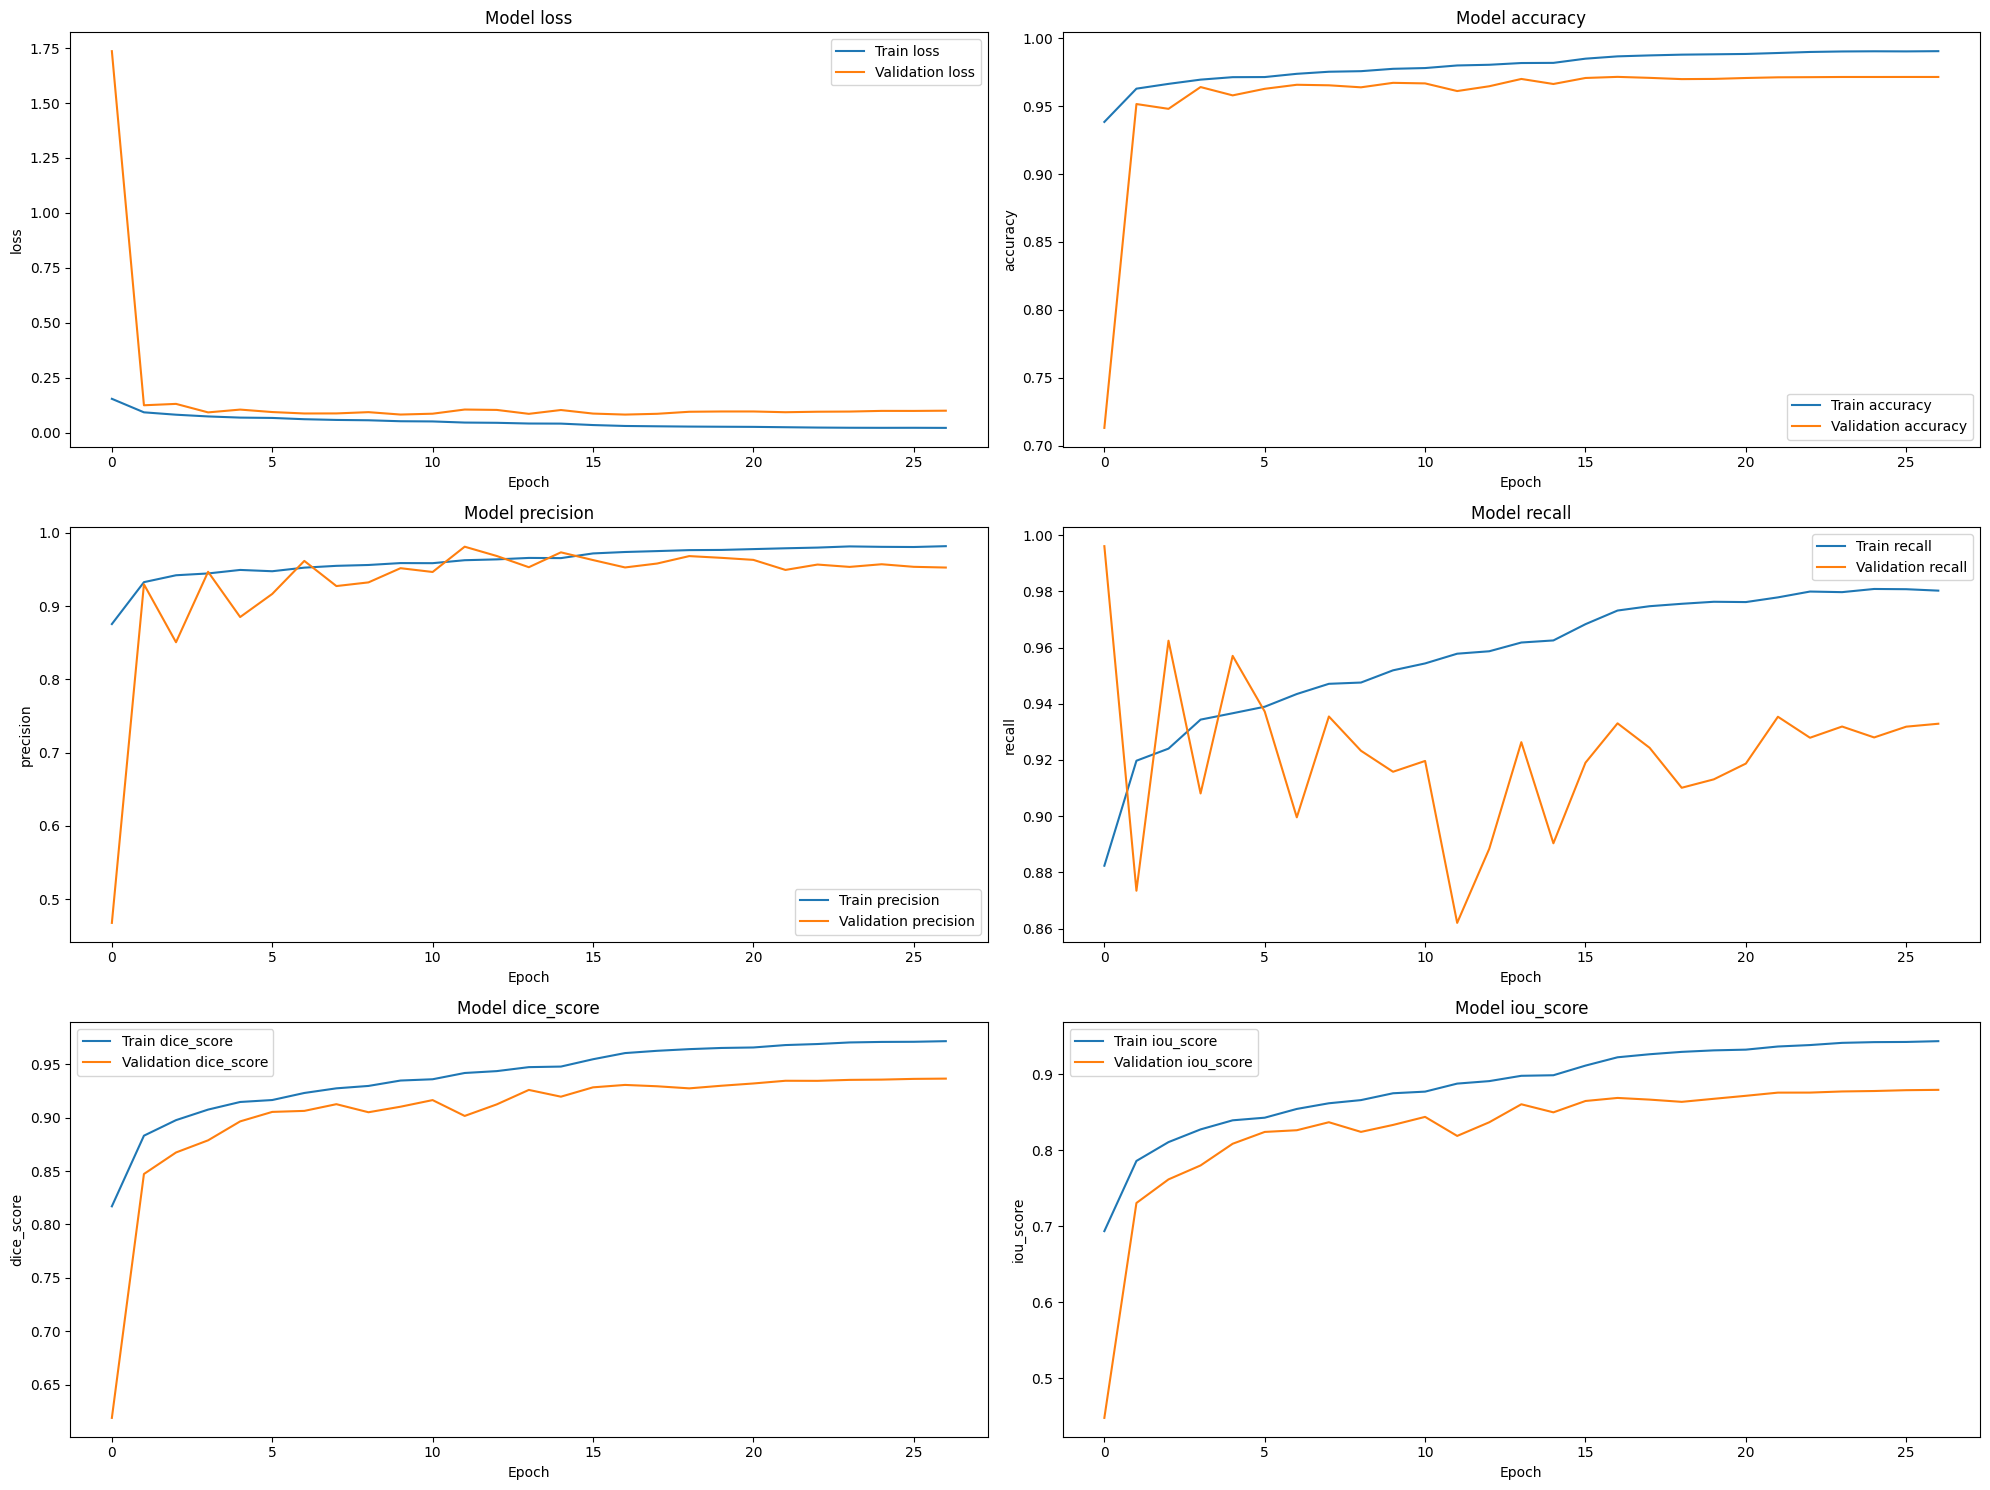

In [117]:
# Plot Training History
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'dice_score', 'iou_score']
    plt.figure(figsize=(20, 15))
    
    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i+1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Model {metric}')
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_metrics(history_seg)

In [118]:
# Evaluate on Test Set
test_results = model.evaluate(X_test, y_test, verbose=0)
test_metrics = dict(zip(model.metrics_names, test_results))

In [120]:
# Print Final Metrics
print("\nFinal Training Metrics:")
for metric in ['loss', 'accuracy', 'precision', 'recall', 'dice_score', 'iou_score']:
    print(f"{metric}: {history.history[metric][-1]:.4f}")

print("\nFinal Validation Metrics:")
for metric in ['loss', 'accuracy', 'precision', 'recall', 'dice_score', 'iou_score']:
    print(f"{metric}: {history.history[f'val_{metric}'][-1]:.4f}")

print("\nTest Set Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")


Final Training Metrics:
loss: 0.0525
accuracy: 0.9782
precision: 0.9606
recall: 0.9531
dice_score: 0.9568
iou_score: 0.9172

Final Validation Metrics:
loss: 0.0813
accuracy: 0.9747
precision: 0.9453
recall: 0.9548
dice_score: 0.9499
iou_score: 0.9046

Test Set Metrics:
loss: 0.0909
compile_metrics: 0.9733


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


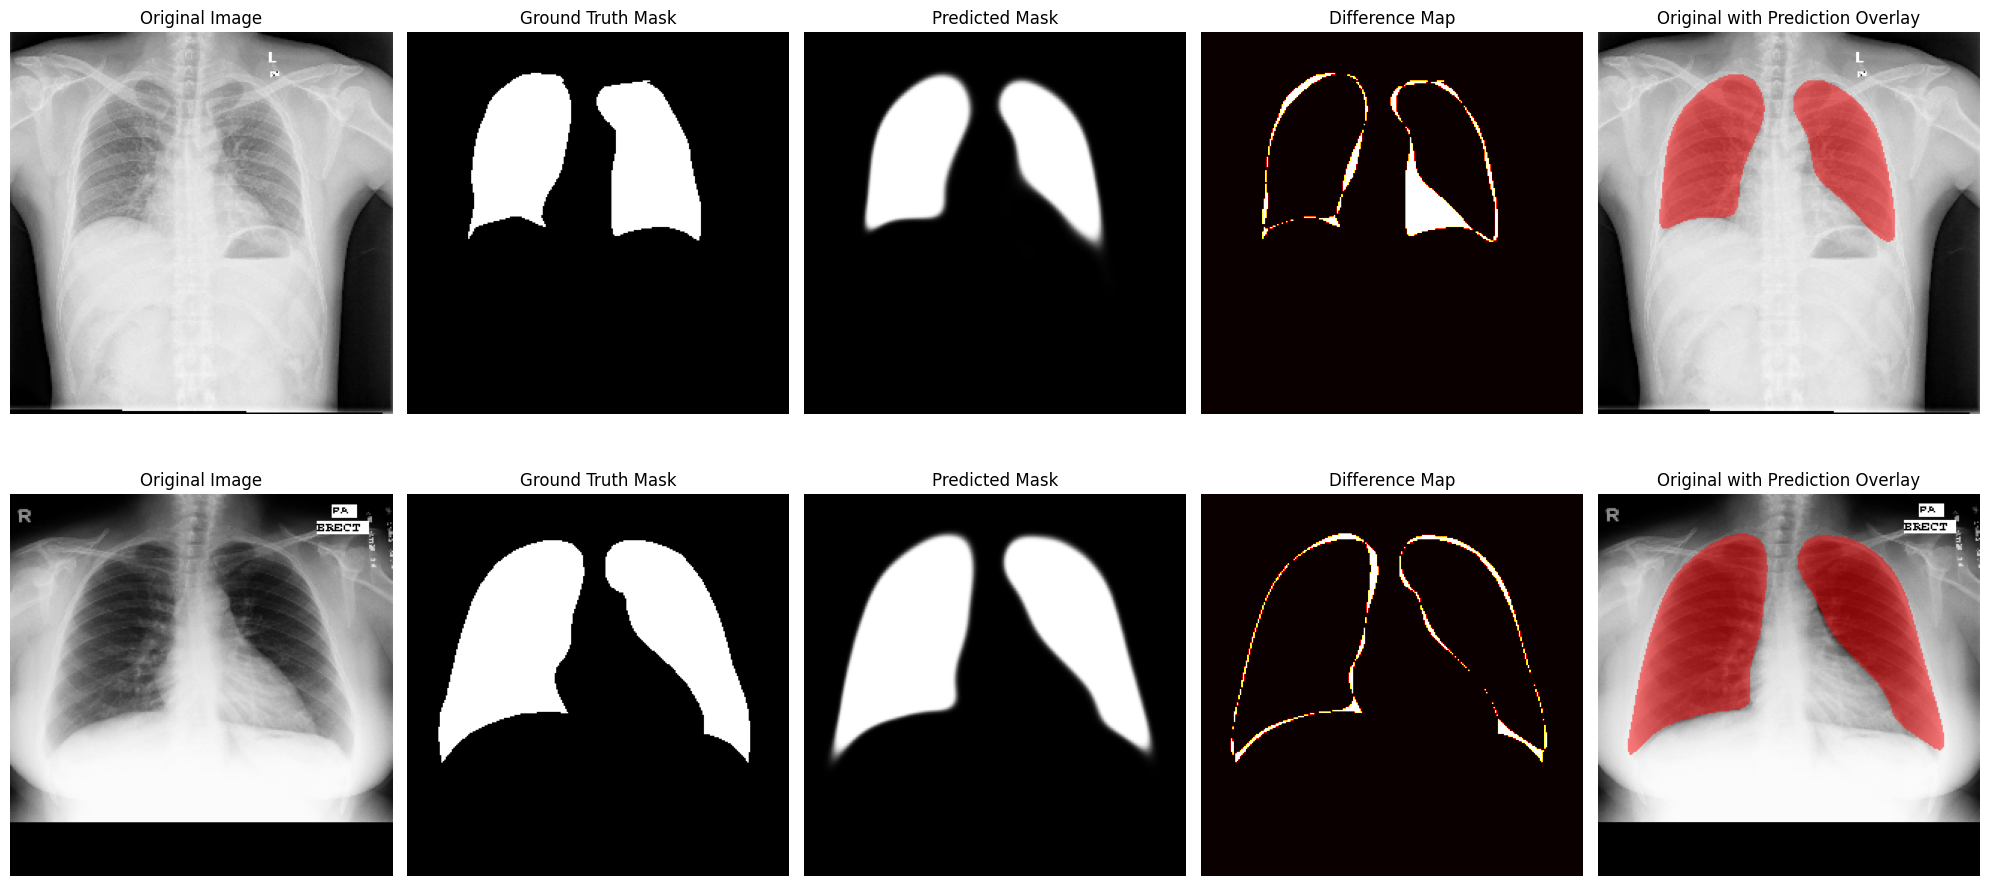

In [123]:
def visualize_predictions(X_test, y_test, model, num_samples=2):
    random_indices = np.random.choice(len(X_test), num_samples, replace=False)
    preds = model.predict(X_test[random_indices])
    
    plt.figure(figsize=(20, 5*num_samples))  # Increased height for new row
    
    for i, idx in enumerate(random_indices):
        # Original Image
        plt.subplot(num_samples, 5, i*5+1)
        plt.imshow(X_test[idx].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')
        
        # Ground Truth
        plt.subplot(num_samples, 5, i*5+2)
        plt.imshow(y_test[idx].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        # Prediction
        plt.subplot(num_samples, 5, i*5+3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
        
        # Difference
        plt.subplot(num_samples, 5, i*5+4)
        diff = np.abs(y_test[idx].squeeze() - (preds[i].squeeze() > 0.5).astype(float))
        plt.imshow(diff, cmap='hot')
        plt.title("Difference Map")
        plt.axis('off')
        
        # Original with Overlay (NEW)
        plt.subplot(num_samples, 5, i*5+5)
        plt.imshow(X_test[idx].squeeze(), cmap='gray')
        
        # Create transparent red mask
        mask = (preds[i].squeeze() > 0.5).astype(float)
        overlay = np.zeros((*mask.shape, 4))  # RGBA array
        overlay[..., 0] = 1.0  # Red channel
        overlay[..., 3] = mask * 0.5  # Alpha channel (50% opacity where mask exists)
        
        plt.imshow(overlay)
        plt.title("Original with Prediction Overlay")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# After training your model:
visualize_predictions(X_test, y_test, model)

In [4]:
import os
import cv2
import numpy as np

image_dir = "/kaggle/input/images"
mask_dir = "/kaggle/input/masks"
IMG_SIZE = 256  # You can change this to 256 if needed

# Preprocess image: grayscale → 3-channel RGB-style
def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0
    img = np.stack((img,) * 3, axis=-1)  # Convert to 3 channels
    return img

# Preprocess mask: single channel (keep grayscale as is)
def preprocess_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = mask.astype(np.float32) / 255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask

def load_dataset(image_dir, mask_dir):
    images, masks = [], []

    # Build mask mapping: remove '-mask' and map base name to mask filename
    mask_files = {fname.split('-mask')[0]: fname for fname in os.listdir(mask_dir) if fname.endswith('.png')}

    matched = 0
    for img_fname in os.listdir(image_dir):
        if not img_fname.endswith('.png'):
            continue

        base_name = img_fname.split('.')[0]
        if base_name in mask_files:
            img_path = os.path.join(image_dir, img_fname)
            mask_path = os.path.join(mask_dir, mask_files[base_name])

            images.append(preprocess_image(img_path))
            masks.append(preprocess_mask(mask_path))
            matched += 1
        else:
            print(f"Skipping {img_fname}: No corresponding mask found.")

    print(f"Total matched image-mask pairs loaded: {matched}")
    return np.array(images), np.array(masks)

# Load the dataset
X, Y = load_dataset(image_dir, mask_dir)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Skipping 94.png: No corresponding mask found.
Skipping 771.png: No corresponding mask found.
Skipping 761.png: No corresponding mask found.
Skipping 403.png: No corresponding mask found.
Skipping 35.png: No corresponding mask found.
Skipping 628.png: No corresponding mask found.
Skipping 441.png: No corresponding mask found.
Skipping 296.png: No corresponding mask found.
Skipping 538.png: No corresponding mask found.
Skipping 89.png: No corresponding mask found.
Skipping 411.png: No corresponding mask found.
Skipping 281.png: No corresponding mask found.
Skipping 362.png: No corresponding mask found.
Skipping 660.png: No corresponding mask found.
Skipping 256.png: No corresponding mask found.
Skipping 4.png: No corresponding mask found.
Skipping 588.png: No corresponding mask found.
Skipping 229.png: No corresponding mask found.
Skipping 331.png: No corresponding mask found.
Skipping 575.png: No corresponding mask found.
Skipping 673.png: No corresponding mask found.
Skipping 658.png: 

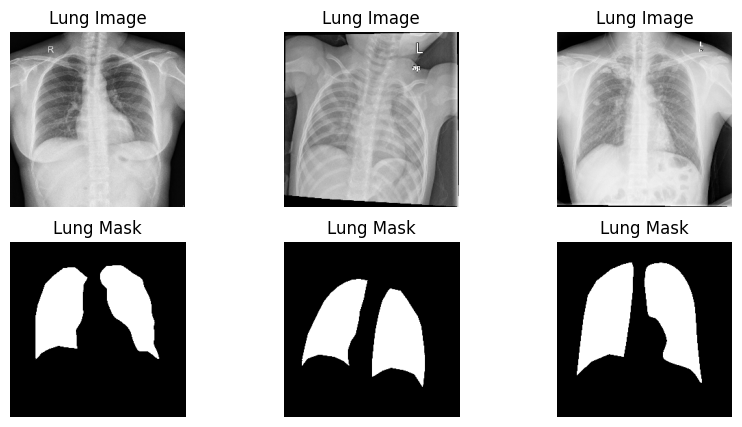

In [97]:
# Display sample images
plt.figure(figsize=(10,5))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].squeeze(), cmap='gray')
    plt.title("Lung Image")
    plt.axis('off')
    
    plt.subplot(2,3,i+4)
    plt.imshow(Y[i].squeeze(), cmap='gray')
    plt.title("Lung Mask")
    plt.axis('off')
plt.show()

**U-Net**

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
from tensorflow.keras import backend as K

In [52]:
# Set dataset paths
image_dir = "/kaggle/input/images"
mask_dir = "/kaggle/input/masks"

def load_dataset(image_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []

    # Extract available mask filenames without "-mask"
    mask_files = {filename.split('-mask')[0]: filename for filename in os.listdir(mask_dir)}

    matched_count = 0
    for filename in os.listdir(image_dir):
        base_name = filename.split('.')[0]  # Extract base name
        
        if base_name in mask_files:  # Only keep images that have masks
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_files[base_name])

            img = load_img(img_path, target_size=img_size, color_mode='grayscale')
            mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')

            images.append(img_to_array(img) / 255.0)
            masks.append(img_to_array(mask) / 255.0)
            matched_count += 1
        else:
            print(f"Skipping {filename}: No corresponding mask found.")

    print(f"Total images with masks loaded: {matched_count}")
    return np.array(images).reshape(-1, 256, 256, 1), np.array(masks).reshape(-1, 256, 256, 1)
 
# Load images and masks
X, Y = load_dataset(image_dir, mask_dir) 

Skipping 94.png: No corresponding mask found.
Skipping 771.png: No corresponding mask found.
Skipping 761.png: No corresponding mask found.
Skipping 403.png: No corresponding mask found.
Skipping 35.png: No corresponding mask found.
Skipping 628.png: No corresponding mask found.
Skipping 441.png: No corresponding mask found.
Skipping 296.png: No corresponding mask found.
Skipping 538.png: No corresponding mask found.
Skipping 89.png: No corresponding mask found.
Skipping 411.png: No corresponding mask found.
Skipping 281.png: No corresponding mask found.
Skipping 362.png: No corresponding mask found.
Skipping 660.png: No corresponding mask found.
Skipping 256.png: No corresponding mask found.
Skipping 4.png: No corresponding mask found.
Skipping 588.png: No corresponding mask found.
Skipping 229.png: No corresponding mask found.
Skipping 331.png: No corresponding mask found.
Skipping 575.png: No corresponding mask found.
Skipping 673.png: No corresponding mask found.
Skipping 658.png: 

In [53]:
# Assuming X and Y are your complete dataset arrays
X = np.array(X)
Y = np.array(Y)

# Split into train+val and test sets first (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Then split train_val into train and validation (75% train, 25% val of the 80% = 60% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (422, 256, 256, 1)
Validation set shape: (141, 256, 256, 1)
Test set shape: (141, 256, 256, 1)


In [54]:
# Define custom metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    return K.mean((intersection + smooth) / (union + smooth), axis=0)

In [55]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
import numpy as np

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    
    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    u1 = Concatenate()([u1, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    
    u2 = UpSampling2D((2, 2))(c5)
    u2 = Concatenate()([u2, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    
    u3 = UpSampling2D((2, 2))(c6)
    u3 = Concatenate()([u3, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs, outputs)
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', 
                           Precision(name='precision'),
                           Recall(name='recall'),
                           dice_coef,
                           iou])
    return model


In [56]:
# Build the model
model = unet_model()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=8,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/20
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7505 - dice_coef: 0.2829 - iou: 0.1659 - loss: 0.9157 - precision: 0.1206 - recall: 0.0018

E0000 00:00:1744469907.719680      79 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744469907.953245      79 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


53/53 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7503 - dice_coef: 0.2842 - iou: 0.1668 - loss: 0.9050 - precision: 0.1206 - recall: 0.0017 - val_accuracy: 0.7480 - val_dice_coef: 0.4330 - val_iou: 0.2745 - val_loss: 0.3940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 412ms/step - accuracy: 0.7628 - dice_coef: 0.3918 - iou: 0.2442 - loss: 0.4483 - precision: 0.3850 - recall: 0.0554 - val_accuracy: 0.8899 - val_dice_coef: 0.5192 - val_iou: 0.3485 - val_loss: 0.3487 - val_precision: 0.9386 - val_recall: 0.6023 - learning_rate: 0.0010
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 410ms/step - accuracy: 0.9103 - dice_coef: 0.6782 - iou: 0.5141 - loss: 0.2637 - precision: 0.8808 - recall: 0.7482 - val_accuracy: 0.9377 - val_dice_coef: 0.7895 - val_iou: 0.6468 - val_loss: 0.1718 - val_precision: 0.9476 - val_recall: 0.7969 - learning_rate: 0.0010
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 407ms/step - accuracy: 0.9469 

In [68]:
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_225 (Conv2D)       │ (None, 256, 256, 64)   │            640 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_226 (Conv2D)       │ (None, 256, 256, 64)   │         36,928 │ conv2d_225[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_45          │ (None, 128, 128, 64)   │              0 │ conv2d_226[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_227 (Conv2D)       │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_45[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_228 (Conv2D)       │ (None, 128, 128, 128)  │        147,584 │ conv2d_227[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_46          │ (None, 64, 64, 128)    │              0 │ conv2d_228[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_229 (Conv2D)       │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_46[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_230 (Conv2D)       │ (None, 64, 64, 256)    │        590,080 │ conv2d_229[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_47          │ (None, 32, 32, 256)    │              0 │ conv2d_230[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_231 (Conv2D)       │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_47[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_232 (Conv2D)       │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_231[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 64, 512)    │              0 │ conv2d_232[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_45            │ (None, 64, 64, 768)    │              0 │ up_sampling2d[0][0],   │
│ (Concatenate)             │                        │                │ conv2d_230[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_233 (Conv2D)       │ (None, 64, 64, 256)    │      1,769,728 │ concatenate_45[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_234 (Conv2D)       │ (None, 64, 64, 256)    │        590,080 │ conv2d_233[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1      

 Total params: 23,345,285 (89.06 MB)

 Trainable params: 7,781,761 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,563,524 (59.37 MB)

In [63]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tensorflow.keras.metrics import MeanIoU

# Evaluate on test set
test_results = model.evaluate(X_test, y_test, verbose=0)
test_metrics = dict(zip(model.metrics_names, test_results))

# Get predictions (probabilities)
y_pred_probs = model.predict(X_test, verbose=0)

# Convert to binary predictions (threshold = 0.5)
y_pred = (y_pred_probs > 0.5).astype(np.uint8)

# Flatten arrays for scikit-learn metrics
y_true_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Calculate additional metrics
test_metrics['sklearn_accuracy'] = accuracy_score(y_true_flat, y_pred_flat)
test_metrics['sklearn_precision'] = precision_score(y_true_flat, y_pred_flat)
test_metrics['sklearn_recall'] = recall_score(y_true_flat, y_pred_flat)

# Calculate IoU
iou = MeanIoU(num_classes=2)
iou.update_state(y_test, y_pred)
test_metrics['mean_iou'] = iou.result().numpy()

# Calculate Dice Coefficient manually
intersection = np.sum(y_true_flat * y_pred_flat)
test_metrics['dice_coef'] = (2. * intersection) / (np.sum(y_true_flat) + np.sum(y_pred_flat))

# Print all metrics in a nice format
print("\n╔══════════════════════════════════════╗")
print("║          Test Set Metrics           ║")
print("╠══════════════════════════╦══════════╣")
print("║ Metric                   ║ Value    ║")
print("╠══════════════════════════╬══════════╣")
for metric, value in test_metrics.items():
    if metric.startswith('val_'):  # Skip validation metrics if present
        continue
    metric_name = metric.replace('_', ' ').title()
    print(f"║ {metric_name:<25} ║ {value:.4f} ║")
print("╚══════════════════════════╩══════════╝")

# Print interpretations
print("\nMetric Interpretations:")
print(f"- Loss: {test_metrics.get('loss', 'N/A'):.4f} (lower is better)")
print(f"- Accuracy: {test_metrics.get('accuracy', test_metrics.get('sklearn_accuracy', 'N/A'))*100:.1f}% correct predictions")
print(f"- Precision: {test_metrics.get('precision', test_metrics.get('sklearn_precision', 'N/A'))*100:.1f}% of positive predictions were correct")
print(f"- Recall: {test_metrics.get('recall', test_metrics.get('sklearn_recall', 'N/A'))*100:.1f}% of actual positives were detected")
print(f"- Dice Coefficient: {test_metrics.get('dice_coef', 'N/A')*100:.1f}% overlap between predictions and ground truth")
print(f"- IoU: {test_metrics.get('iou', test_metrics.get('mean_iou', 'N/A'))*100:.1f}% intersection over union")


╔══════════════════════════════════════╗
║          Test Set Metrics           ║
╠══════════════════════════╦══════════╣
║ Metric                   ║ Value    ║
╠══════════════════════════╬══════════╣
║ Loss                      ║ 0.0623 ║
║ Compile Metrics           ║ 0.9779 ║
║ Sklearn Accuracy          ║ 0.9779 ║
║ Sklearn Precision         ║ 0.9650 ║
║ Sklearn Recall            ║ 0.9469 ║
║ Mean Iou                  ║ 0.9432 ║
║ Dice Coef                 ║ 0.9559 ║
╚══════════════════════════╩══════════╝

Metric Interpretations:
- Loss: 0.0623 (lower is better)
- Accuracy: 97.8% correct predictions
- Precision: 96.5% of positive predictions were correct
- Recall: 94.7% of actual positives were detected
- Dice Coefficient: 95.6% overlap between predictions and ground truth
- IoU: 94.3% intersection over union


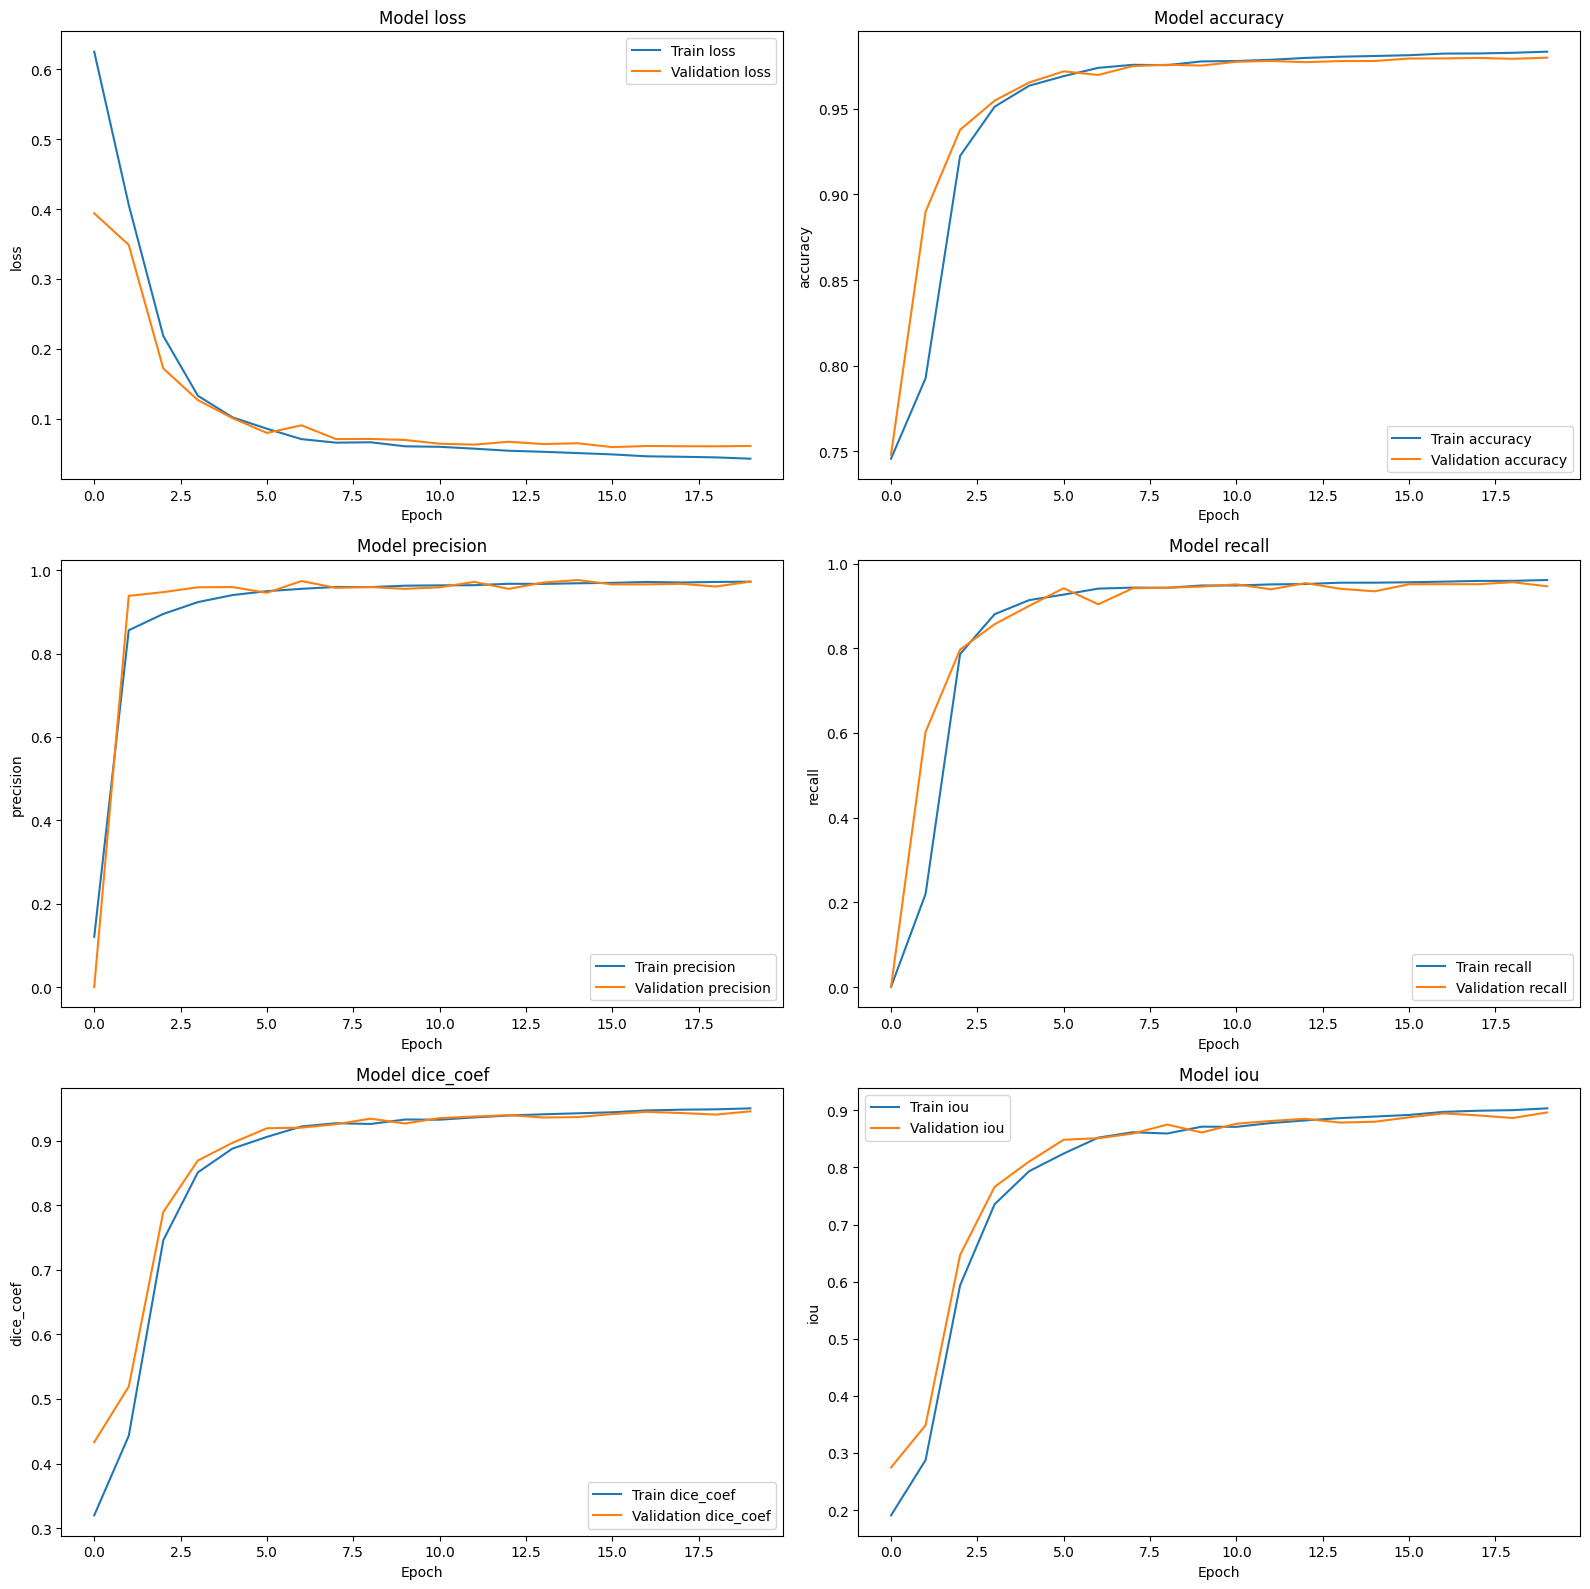

In [60]:
# Plot training history
def plot_history(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'dice_coef', 'iou']
    
    plt.figure(figsize=(16, 16))
    
    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i+1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Model {metric}')
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [62]:
# Print final results
def print_metrics(metrics_dict, title):
    print(f"\n{title}:")
    for metric, value in metrics_dict.items():
        if isinstance(value, (list, np.ndarray)):
            value = value[-1]  # Get last epoch value
        print(f"{metric}: {value:.4f}")

# Training results (from last epoch)
train_metrics = {metric: history.history[metric][-1] 
                 for metric in history.history 
                 if not metric.startswith('val_')}
print_metrics(train_metrics, "Final Training Results")

# Validation results (from last epoch)
val_metrics = {metric[4:]: history.history[metric][-1] 
               for metric in history.history 
               if metric.startswith('val_')}
print_metrics(val_metrics, "Final Validation Results")

# Test results
print_metrics(test_metrics, "Test Set Results")


Final Training Results:
accuracy: 0.9833
dice_coef: 0.9501
iou: 0.9036
loss: 0.0428
precision: 0.9727
recall: 0.9613
learning_rate: 0.0003

Final Validation Results:
accuracy: 0.9798
dice_coef: 0.9455
iou: 0.8964
loss: 0.0610
precision: 0.9728
recall: 0.9464

Test Set Results:
loss: 0.0623
compile_metrics: 0.9779


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Showing X-ray, Ground Truth Mask, Predicted Mask, and Overlap:


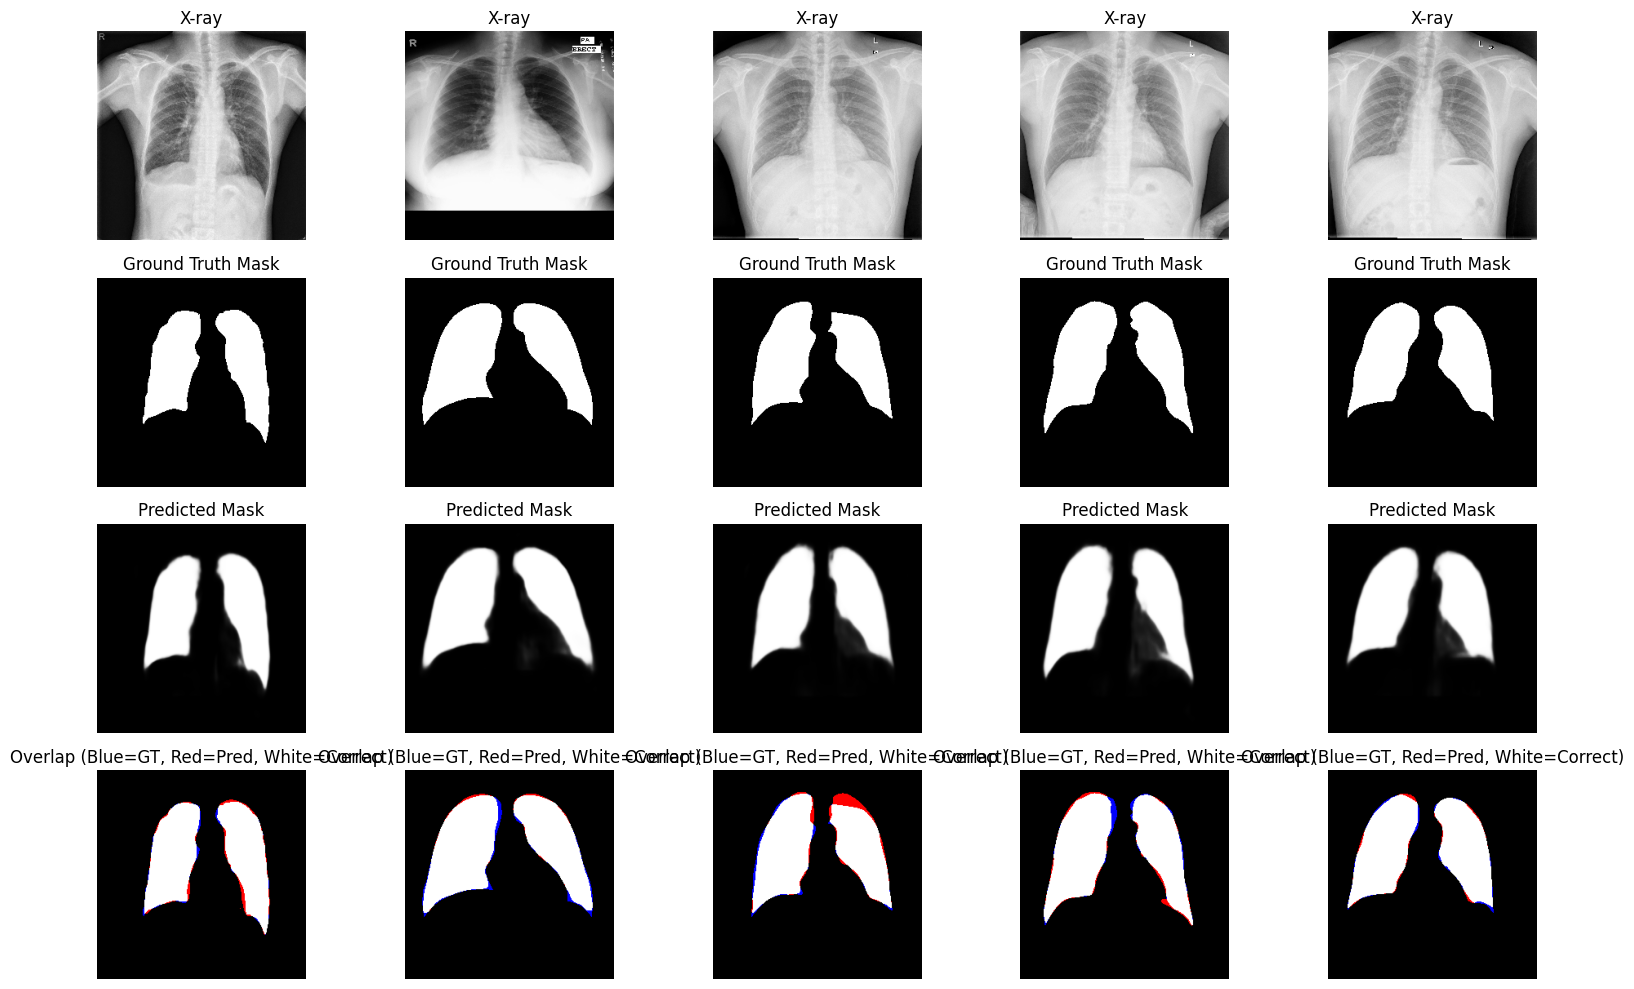

In [67]:
# Visualization of predictions on test samples
# Select 5 random indices from the test dataset
random_indices = np.random.choice(len(X_test), 5, replace=False)

# Generate predictions for the selected test samples
pred = model.predict(X_test[random_indices])

print("\nShowing X-ray, Ground Truth Mask, Predicted Mask, and Overlap:")
plt.figure(figsize=(16, 10))

for i, idx in enumerate(random_indices):
    # Original X-ray
    plt.subplot(4, 5, i+1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')
    plt.title("X-ray")
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(4, 5, i+6)
    plt.imshow(y_test[idx].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(4, 5, i+11)
    plt.imshow(pred[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    # Overlap Visualization
    plt.subplot(4, 5, i+16)
    
    y_true = y_test[idx].squeeze()
    y_pred = (pred[i].squeeze() > 0.5).astype(np.uint8)  # Convert to binary mask

    # Create color-coded overlay
    overlap = np.zeros((y_true.shape[0], y_true.shape[1], 3))  # RGB image
    overlap[y_true == 1] = [0, 0, 1]  # Blue = Ground Truth
    overlap[y_pred == 1] = [1, 0, 0]  # Red = Prediction
    overlap[(y_true == 1) & (y_pred == 1)] = [1, 1, 1]  # White = Correct Segmentation

    plt.imshow(overlap)
    plt.title("Overlap (Blue=GT, Red=Pred, White=Correct)")
    plt.axis('off')

plt.tight_layout()
plt.show()